## IN PROGRESS

In [1]:
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from utility_functions import load_file, pickle_file, starting_run, finished_run

In [2]:
filtered_dataset = load_file("summary_enhanced.pickle")
filtered_dataset_codes = load_file("filtered_dataset_codes.pickle")

In [3]:
code_lookup = {
    "cpt": load_file("cpt_code_translation_dict.pickle"),
    "icd": load_file("icd_code_translation_dict.pickle"),
    "icd_proc": load_file("icd_procedure_code_translation_dict.pickle")
}

### Distribution of Demographics

In [4]:
demographics_dict = {
    "age_groups": "Age Groups",
    "marital_status": "Marital Status",
    "payer": "Expected Payer",
    "gender": "Gender",
    "homeless": "Homelessness Status",
    "race": "Race",
    "median_zip_income": "Patient's County's National Income Quartile",
    "ED_revisits": "Emergency Department Readmissions",
    "inpatient_visits": "Inpatient Admissions"
}
num_demographics = len(demographics_dict.keys())

In [5]:
def plot_demographic_data(data_collection, fig_title, demographics_dict):
    fig, ax = plt.subplots(num_demographics, len(data_collection.keys()), figsize=(40,50))
    if not os.path.isdir(f"../tables/{fig_title}_tables"):
        os.mkdir(f"../tables/{fig_title}_tables")
    for dem_index, demographic in enumerate(demographics_dict.keys()):
        summary_table = pd.DataFrame()
        for data_index, dataset in enumerate(data_collection.keys()):
            plot_series = data_collection[dataset][demographic].astype("str").value_counts().sort_index()
            ax[dem_index, data_index].bar(plot_series.index, plot_series)
            ax[dem_index, data_index].set_title(
                f"{dataset} {demographics_dict[demographic]} Distribution, N={data_collection[dataset][demographic].count()}"
            )
            ax[dem_index, data_index].set_xlabel(f"{demographics_dict[demographic]}")
            ax[dem_index, data_index].set_ylabel("Number of Patients")
            summary_table[dataset] = plot_series
        summary_table.to_csv(f"../tables/{fig_title}_tables/{demographic}.csv")
    fig.savefig(f"../figures/{fig_title}.png")
    plt.close()    

In [6]:
plot_demographic_data(split_filtered_datasets, "filtered_demographic_counts", demographics_dict)

In [7]:
plot_demographic_data(split_full_datasets, "full_demographic_counts", demographics_dict)

### Comorbidity Analysis

In [8]:
def plot_comorbidities(data_collection, fig_title):
    def plot_codes(codes, axes, col_name, title_addendum):
        axes.bar(codes.index, codes)
        axes.set_title(f"Most Frequent Code Occurances in {title_addendum}")
        axes.set_xlabel(f"{col_name[:-4]} code")
        axes.set_ylabel("Percent of Occurances")
        return codes
    fig, ax = plt.subplots(6, len(data_collection.keys()), figsize=(80,50))
    summary_tables = {}
    for index, dataset in enumerate(data_collection.keys()):
        code_counts = data_collection[dataset].groupby("codes").count()
        pt_code_counts = data_collection[dataset].reset_index().drop_duplicates(keep="first").set_index("visit_link").groupby("codes").count()
        for y_index, col_name in enumerate(code_counts.columns):
            if f"{col_name[:-5]}" not in summary_tables.keys():
                summary_tables[f"{col_name[:-5]}"] = []
            summary_tables[f"{col_name[:-5]}"].append(plot_codes(
                code_counts[col_name].sort_values().tail(10).apply(lambda val: val/code_counts[col_name].sum()),
                ax[2*y_index, index], col_name, dataset
            ).rename(f"{dataset}_total"))
            summary_tables[f"{col_name[:-5]}"].append(plot_codes(
                pt_code_counts[col_name].sort_values().tail(10).apply(lambda val: val/code_counts[col_name].sum()),
                ax[2*y_index+1, index], col_name, f"{dataset} (Once per Patient)"
            ).rename(f"{dataset}_per_pt"))
    fig.savefig(f"../figures/{fig_title}.png")
    plt.close()
    if not os.path.isdir(f"../tables/{fig_title}_tables"):
        os.mkdir(f"../figures/{fig_title}_tables")
    for dataset, summary_table in summary_tables.items():
        summary_table = pd.DataFrame(summary_table).transpose()
        summary_table["code_meaning"] = summary_table.index.to_series().apply(
            lambda x: code_lookup[dataset][x.strip()] if x.strip() in code_lookup[dataset].keys() else None
        )
        summary_table.sort_values(by="full_total", ascending=False).to_csv(f"../tables/{fig_title}_tables/{dataset}.csv")
        plot = summary_table.plot(
            kind="bar",
            figsize=(20,10),
            title=f"{dataset} code distribution across datasets"
        )
        plot.set_xlabel(f"{dataset[0:3]} code")
        plot.set_ylabel(f"Percentage of dataset rows")
        plt.savefig(f"../figures/{dataset}_{fig_title}.png")
        plt.show()
        print()
        print()
        print()

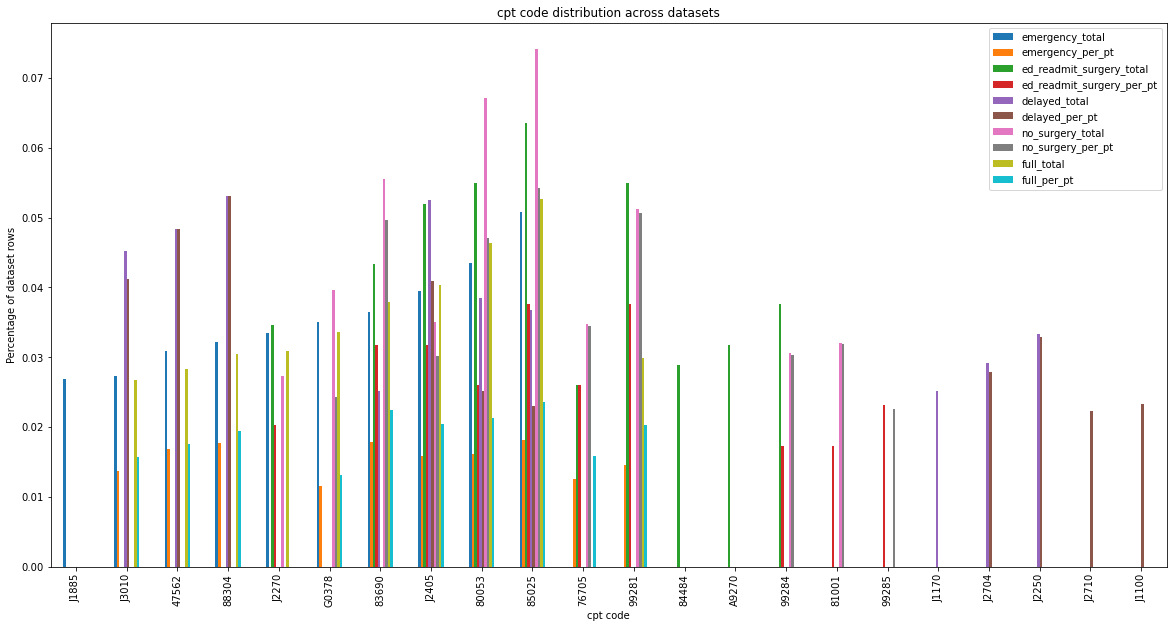

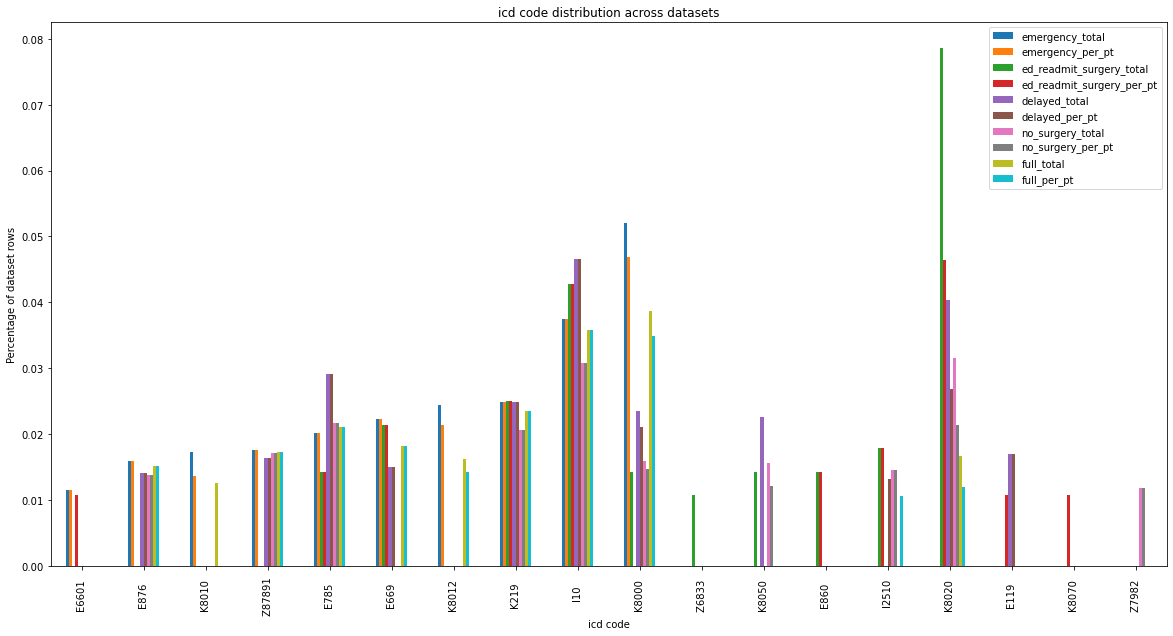

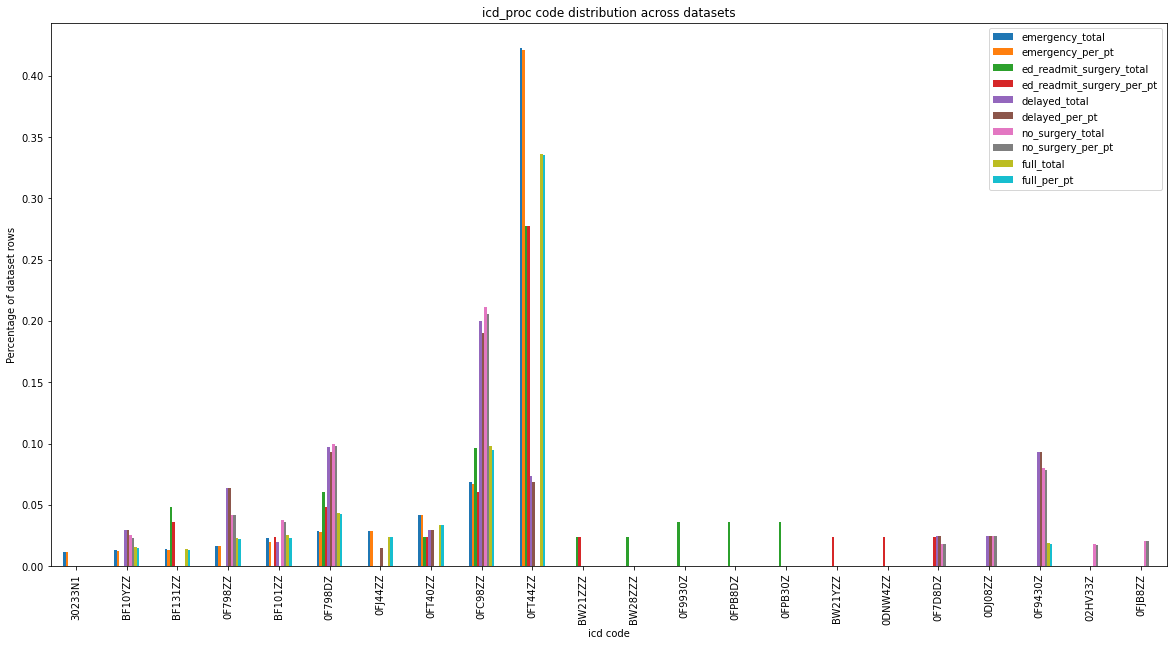

In [9]:
plot_comorbidities(split_filtered_dataset_codes, "comorbidities_filtered")

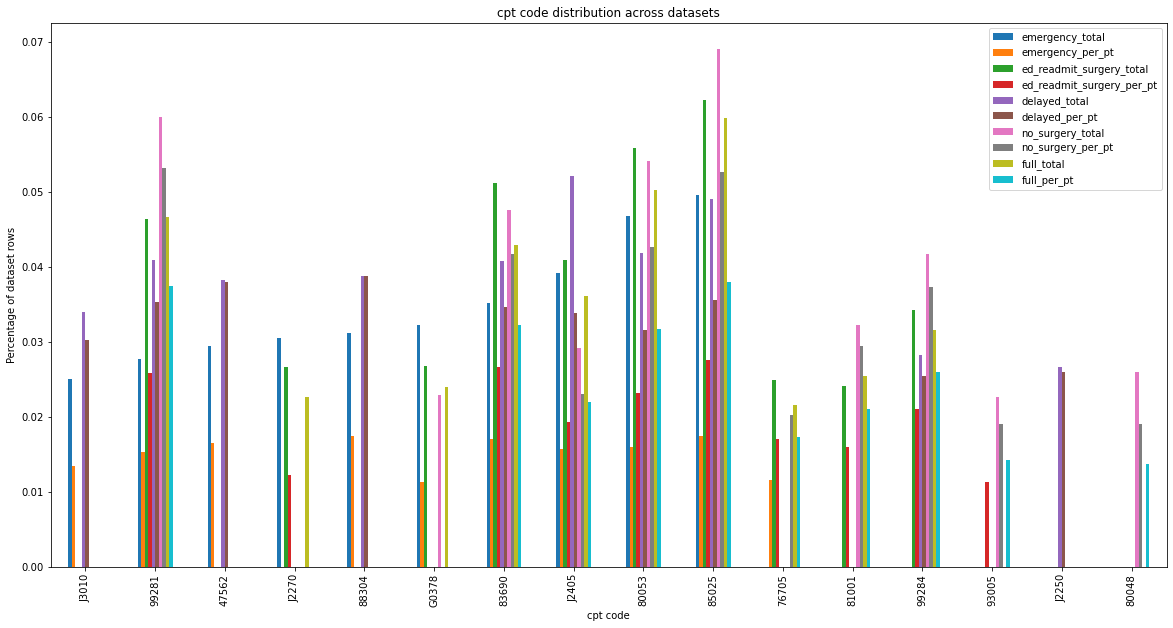

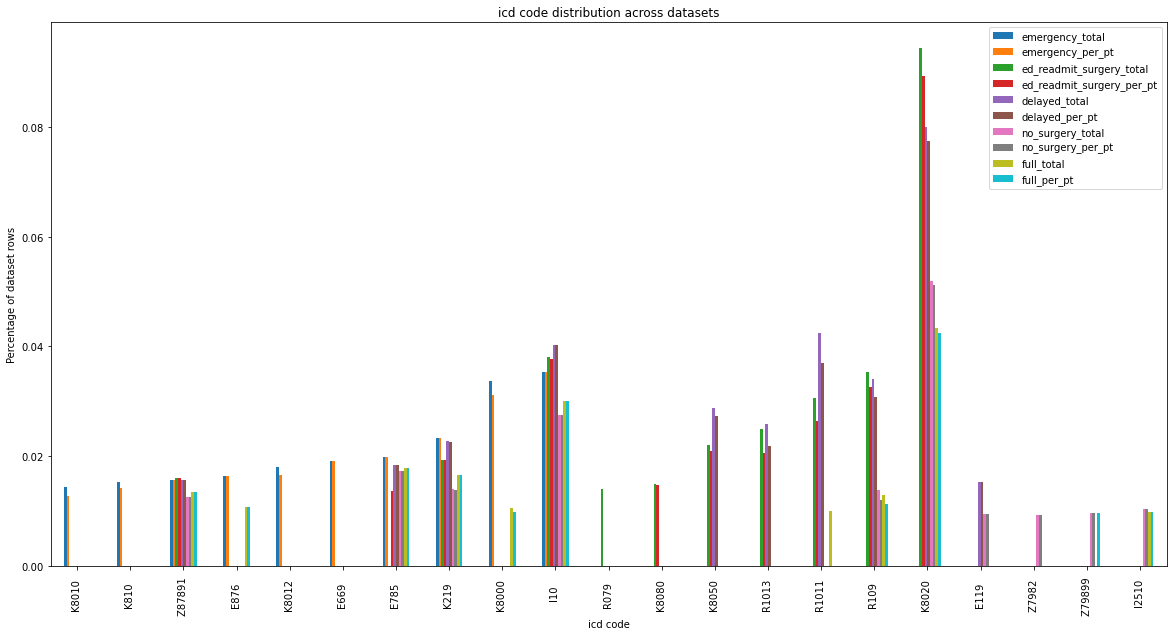

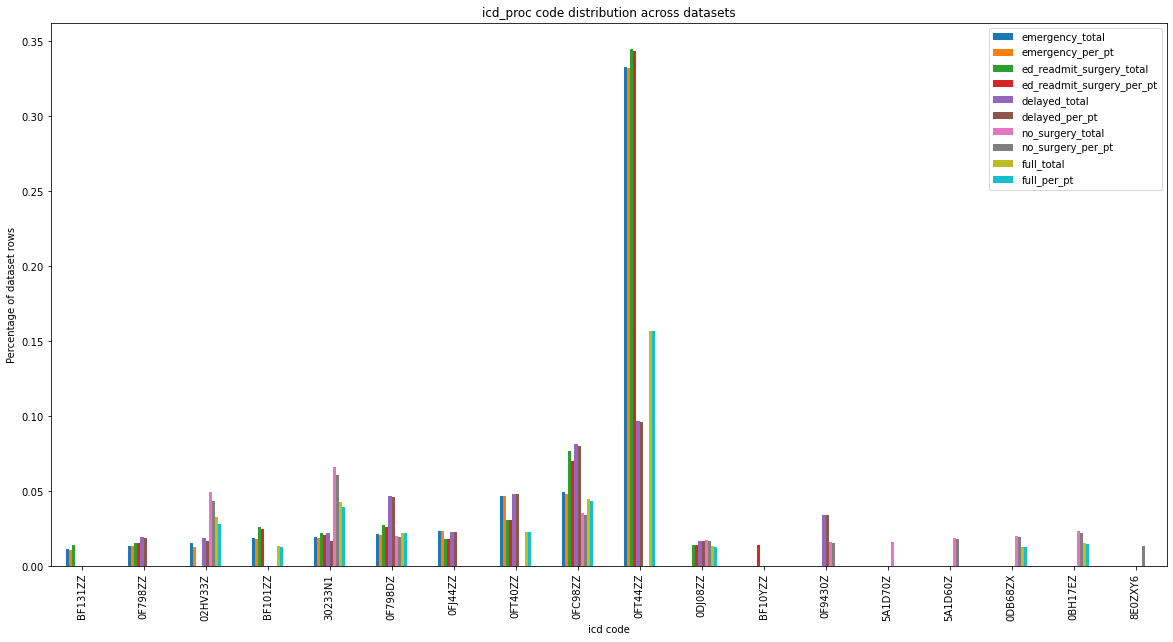

In [10]:
plot_comorbidities(split_full_dataset_codes, "comorbidities_full")

### Charges Analysis

In [11]:
split_filtered_datasets["full"].groupby("surgery_type")["total_charges"].mean()

surgery_type
delayed               16178.142857
ed_readmit_surgery    23817.142857
emergency             17036.123043
no_surgery             9764.311562
Name: total_charges, dtype: float64

In [12]:
split_full_datasets["full"].groupby("surgery_type")["total_charges"].mean()

surgery_type
delayed               13233.738841
ed_readmit_surgery    21034.606897
emergency             20392.334378
no_surgery            10502.799949
Name: total_charges, dtype: float64

In [13]:
split_filtered_datasets["full"].groupby("surgery_type")["ED_revisits"].mean()

surgery_type
delayed               0.043290
ed_readmit_surgery    1.000000
emergency             0.009829
no_surgery            0.028244
Name: ED_revisits, dtype: float64

In [14]:
split_full_datasets["full"].groupby("surgery_type")["ED_revisits"].mean()

surgery_type
delayed               0.137908
ed_readmit_surgery    1.117241
emergency             0.022158
no_surgery            0.083805
Name: ED_revisits, dtype: float64